<a href="https://colab.research.google.com/github/easoplee/spine_segmentation/blob/main/lumbar_spine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lumbar Spine Bone (L1-S1) Segmentation
- dataset can be accessed from: https://data.mendeley.com/datasets/k3b363f3vz/2

In [1]:
new_training = False

### Import necessary packages

In [2]:
#pip install packages

!pip install itk
!pip install itkwidgets
!pip install pydicom
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#import necessary packages

import pathlib as Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence 
import torch.nn.functional as F
import os
import pydicom as dicom
import matplotlib.patches as mpatches
import matplotlib.animation as animation
import matplotlib.image as img
import zipfile
import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import time
from PIL import Image
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Download the dataset from google drive

In [4]:
# mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
class config:
  BATCH_SIZE = 20
  NUM_CLASS = 7
  INPUT_IMAGE_HEIGHT = 224
  INPUT_IMAGE_WIDTH = 224
  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
  PIN_MEMORY = True if DEVICE == "cuda" else False
  LEARNING_RATE = 3e-5
  NUM_EPOCHS = 35
  MODEL_PATH = "/content/drive/MyDrive/lumbar_mid_sagittal/output/multi_model.pth"
  PLOT_PATH = "/content/drive/MyDrive/lumbar_mid_sagittal/output/plot.png"

In [6]:
#unzip the zip file
!unzip -u "/content/drive/MyDrive/lumbar_mid_sagittal.zip" -d "/content/drive/MyDrive/"

Archive:  /content/drive/MyDrive/lumbar_mid_sagittal.zip


In [7]:
#download the image and ground truth mask
image_dir = '/content/drive/MyDrive/lumbar_mid_sagittal/Images/'
label_dir = '/content/drive/MyDrive/lumbar_mid_sagittal/Pseudo_Colored_Ground_Truth_Images'

#print out the number of images and labels
print(f'Total number of MRI scans: {len(os.listdir(image_dir))}')
print(f'Total number of MRI labels: {len(os.listdir(label_dir))}')

Total number of MRI scans: 514
Total number of MRI labels: 514


In [8]:
DIR_SIZE = len(os.listdir(image_dir))
print(sorted(os.listdir(image_dir)))

['T1_0001_S8.png', 'T1_0002_S8.png', 'T1_0003_S8.png', 'T1_0004_S7.png', 'T1_0005_S8.png', 'T1_0006_S8.png', 'T1_0007_S8.png', 'T1_0008_S7.png', 'T1_0009_S7.png', 'T1_0010_S8.png', 'T1_0011_S8.png', 'T1_0012_S8.png', 'T1_0013_S8.png', 'T1_0014_S8.png', 'T1_0015_S8.png', 'T1_0016_S8.png', 'T1_0017_S8.png', 'T1_0019_S8.png', 'T1_0020_S15.png', 'T1_0021_S8.png', 'T1_0022_S8.png', 'T1_0023_S8.png', 'T1_0024_S7.png', 'T1_0025_S8.png', 'T1_0026_S8.png', 'T1_0027_S14.png', 'T1_0029_S7.png', 'T1_0030_S8.png', 'T1_0031_S8.png', 'T1_0032_S8.png', 'T1_0033_S8.png', 'T1_0034_S8.png', 'T1_0035_S8.png', 'T1_0036_S8.png', 'T1_0037_S7.png', 'T1_0038_S8.png', 'T1_0039_S8.png', 'T1_0040_S8.png', 'T1_0041_S8.png', 'T1_0042_S15.png', 'T1_0043_S8.png', 'T1_0044_S8.png', 'T1_0046_S8.png', 'T1_0047_S8.png', 'T1_0048_S8.png', 'T1_0050_S8.png', 'T1_0051_S8.png', 'T1_0052_S8.png', 'T1_0053_S8.png', 'T1_0055_S15.png', 'T1_0056_S8.png', 'T1_0057_S8.png', 'T1_0058_S8.png', 'T1_0060_S8.png', 'T1_0061_S8.png', 'T1_0

## Visualize an example image and label



In [9]:
#parameters: img_dir -> string that specifies where the images are stored at; label_dir -> similar

def view_img_label(img_dir, label_dir):
  dir_size = DIR_SIZE
  #rand_int = np.random.randint(0, dir_size-1)
  rand_int=0
  ex_img_dir = os.path.join(image_dir, sorted(os.listdir(image_dir))[rand_int])
  #print(ex_img_dir)
  ex_img = cv2.imread(ex_img_dir)
  ex_label_dir = os.path.join(label_dir, sorted(os.listdir(label_dir))[rand_int])
  #print(ex_label_dir)
  ex_label = cv2.imread(ex_label_dir)
  return ex_img, ex_label, ex_img_dir, ex_label_dir

image shape: (320, 320, 3)
label shape: (320, 320, 3)


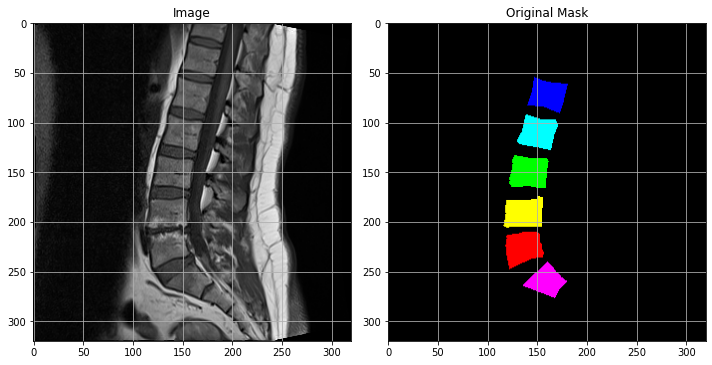

In [10]:
#!pip install matplotlib==3.1.3
ex_img, ex_label, ex_img_dir, ex_label_dir = view_img_label(image_dir, label_dir)
print(f'image shape: {ex_img.shape}')
print(f'label shape: {ex_label.shape}')
#print(ex_img)
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
# plot the original image, its mask, and the predicted mask
ax[0].imshow(ex_img)
ax[1].imshow(ex_label)

# set the titles of the subplots
ax[0].set_title("Image")
ax[1].set_title("Original Mask")
ax[0].grid(True)
ax[1].grid(True)

# set the layout of the figure and display it
figure.tight_layout()
figure.show()

## Data formatting
- mask shape: [height x width] and contain class indices for each pixel location in the range (0, nb_classes=7)

In [11]:
#TODO: print out all the unique color labels

#flatten out the image -> [[R,G,B]*(width*height)]
def flatten_img(img):
  width = img.shape[0]
  height = img.shape[1]

  temp = []

  for w in range(width):
    for h in range(height):
      temp.append(img[w, h])
  return temp

ex_label_flatten = flatten_img(ex_label)

unique_data = [list(x) for x in set(tuple(x) for x in ex_label_flatten)]
print("unique RGB values: ", unique_data)

#[[0, 255, 255], [255, 255, 0], [0, 0, 255], [255, 0, 0], [255, 0, 255], [0, 0, 0], [0, 255, 0]]

unique RGB values:  [[0, 255, 255], [255, 255, 0], [0, 0, 255], [255, 0, 0], [255, 0, 255], [0, 0, 0], [0, 255, 0]]


In [12]:
#given an color-coded mask, format in such that each pixel location in the range contains an integer from 0 to 7
colorToClass = {
    (0, 0, 0) : 'background',
    (255, 255, 0) : 'L1',
    (255, 0, 0) : 'L2',
    (0, 255, 0) : 'L3',
    (0, 255, 255) : 'L4',
    (0, 0, 255) : 'L5',
    (255, 0, 255) : 'S1'
}

classToInt = {
    'background': 0,
    'L1': 1,
    'L2': 2,
    'L3': 3,
    'L4': 4,
    'L5': 5,
    'S1': 6
}

IntToColor = {
    0: (0, 0, 0),
    1: (255, 255, 0),
    2: (255, 0, 0),
    3: (0, 255, 0),
    4: (0, 255, 255),
    5: (0, 0, 255),
    6: (255, 0, 255)
}

def RGBtoInt(label_img):
  temp = np.zeros((label_img.shape[0], label_img.shape[1]))
  for i in range(label_img.shape[0]):
    for j in range(label_img.shape[1]):
      temp[i, j] = int(classToInt.get(colorToClass.get(tuple(label_img[i, j]))))
  return temp

#test RGBtoInt function
test_label_Int = RGBtoInt(ex_label)
print("unique labels: ", np.unique(test_label_Int))
non_background = 0
for i in range(test_label_Int.shape[0]):
  for j in range(test_label_Int.shape[1]):
    if int(test_label_Int[i,j]) == 0:
      non_background += 1

total_pixels = test_label_Int.shape[0] * test_label_Int.shape[1]
print(f'Percentage of background: {"{:.2f}".format(non_background/total_pixels*100)}%')


unique labels:  [0. 1. 2. 3. 4. 5. 6.]
Percentage of background: 94.22%


### Resize to (config.HEIGHT, config.WIDTH)


In [13]:
def resize_img(img, img_stack=1):
  width = config.INPUT_IMAGE_WIDTH #224
  height = config.INPUT_IMAGE_HEIGHT #224
  img_stack_sm = np.zeros((width, height, img_stack)) #empty list of (3, 224, 224)

  if img_stack==1:
    img_stack_sm = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
  else:
    for idx in range(img_stack):
      img2 = img[:, :, idx]
      #print(img2.shape)
      img_sm = cv2.resize(img2, (width, height), interpolation=cv2.INTER_NEAREST)
      #print(img_sm.shape)
      img_stack_sm[:, :, idx] = img_sm
  return img_stack_sm

test_resize_img= resize_img(ex_img, 3)
print("resized image shape: ", test_resize_img.shape)

resized image shape:  (224, 224, 3)


##Create SpineData class

In [14]:
class spineData(Dataset):
  def __init__(self, path, label_path, fileList):
    #self.files = sorted(os.listdir(path))
    #self.labels = sorted(os.listdir(label_path))
    #self.transform = transform
    self.path = path
    self.labelpath = label_path
    self.fileList = fileList

  def __len__(self):
    return len(self.fileList)

  def __getitem__(self, index):
    filename = os.path.join(self.path, self.fileList[index])

    tensor_image = cv2.imread(filename)
    tensor_image = cv2.resize(tensor_image, (config.INPUT_IMAGE_WIDTH, config.INPUT_IMAGE_HEIGHT))
    tensor_image = torch.Tensor(tensor_image/255)
    tensor_image = torch.permute(tensor_image, (2,0,1))

    label_filename = os.path.join(self.labelpath, self.fileList[index])
    label = cv2.imread(label_filename)
    label = resize_img(RGBtoInt(label))
    tensor_label = torch.LongTensor(label)

    return tensor_image, tensor_label

## Split to train/test

In [15]:
print(image_dir)
print(label_dir)

valset_length = int(len(os.listdir(image_dir)) * 0.1)

image_list = sorted(os.listdir(image_dir))
random.shuffle(image_list)

val_list = sorted(image_list[:valset_length])
train_list = sorted(image_list[valset_length:])

print(val_list)

train_spine_dataset = spineData(image_dir, label_dir, train_list)
test_spine_dataset = spineData(image_dir, label_dir, val_list)

/content/drive/MyDrive/lumbar_mid_sagittal/Images/
/content/drive/MyDrive/lumbar_mid_sagittal/Pseudo_Colored_Ground_Truth_Images
['T1_0006_S8.png', 'T1_0011_S8.png', 'T1_0020_S15.png', 'T1_0034_S8.png', 'T1_0060_S8.png', 'T1_0078_S8.png', 'T1_0087_S8.png', 'T1_0100_S8.png', 'T1_0101_S8.png', 'T1_0106_S8.png', 'T1_0119_S8.png', 'T1_0153_S8.png', 'T1_0158_S8.png', 'T1_0180_S8.png', 'T1_0185_S7.png', 'T1_0226_S8.png', 'T1_0228_S8.png', 'T1_0229_S8.png', 'T1_0230_S5.png', 'T1_0247_S8.png', 'T1_0259_S8.png', 'T1_0260_S8.png', 'T1_0263_S8.png', 'T1_0301_S8.png', 'T1_0303_S8.png', 'T1_0307_S8.png', 'T1_0314_S8.png', 'T1_0316_S8.png', 'T1_0326_S8.png', 'T1_0335_S8.png', 'T1_0338_S8.png', 'T1_0347_S8.png', 'T1_0384_S8.png', 'T1_0393_S8.png', 'T1_0400_S8.png', 'T1_0403_S8.png', 'T1_0410_S8.png', 'T1_0417_S8.png', 'T1_0421_S8.png', 'T1_0423_S7.png', 'T1_0434_S8.png', 'T1_0435_S8.png', 'T1_0443_S8.png', 'T1_0466_S8.png', 'T1_0479_S8.png', 'T1_0500_S8.png', 'T1_0504_S8.png', 'T1_0525_S7.png', 'T1_0

In [16]:
#plt.imshow(spine_dataset[0][0])

print(np.unique(train_spine_dataset[0][1])) #resize with keeping new labels
print(train_spine_dataset[0][0].shape)
print(train_spine_dataset[0][1].shape)
print(len(train_spine_dataset))

print(np.unique(test_spine_dataset[0][1])) #resize with keeping new labels
print(test_spine_dataset[0][0].shape)
print(test_spine_dataset[0][1].shape)
print(len(test_spine_dataset))

[0 1 2 3 4 5 6]
torch.Size([3, 224, 224])
torch.Size([224, 224])
463
[0 1 2 3 4 5 6]
torch.Size([3, 224, 224])
torch.Size([224, 224])
51


## Make dataloaders

In [17]:
train_dataloader = DataLoader(train_spine_dataset, shuffle=True,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())

train_x, train_y = next(iter(train_dataloader))

print(f'train_x = shape: {train_x.shape}; type: {train_x.dtype}')
print(f'train_x = min: {train_x.min()}; max: {train_x.max()}')
#print(f'train_y = shape: {train_y.shape}; class: {train_y.unique()}; type: {train_y.dtype}')

val_dataloader = DataLoader(test_spine_dataset, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())

val_x, val_y = next(iter(val_dataloader))
print(f'val_x = shape: {val_x.shape}')
print(f'val_y = shape: {val_y.shape}')

dataloaders = {
  'train': train_dataloader,
  'val': val_dataloader
}

print(len(train_dataloader))
print(len(val_dataloader))

train_x = shape: torch.Size([20, 3, 224, 224]); type: torch.float32
train_x = min: 0.0; max: 0.9803921580314636
val_x = shape: torch.Size([20, 3, 224, 224])
val_y = shape: torch.Size([20, 224, 224])
24
3


## 2D U-Net Architecture

In [18]:
#import torchvision
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False, progress=True, num_classes=7, aux_loss=None)
if (not(new_training)): # if training is unnecessary
  #model.load_state_dict(torch.load(config.MODEL_PATH))
  model = torch.load(config.MODEL_PATH).to(config.DEVICE)
model = model.to(config.DEVICE)
model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## TRAINING

In [19]:
if (new_training):
  optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
  loss_function = nn.CrossEntropyLoss()

  # calculate steps per epoch for training and test set
  trainSteps = len(train_spine_dataset) // config.BATCH_SIZE
  testSteps = len(test_spine_dataset) // config.BATCH_SIZE

  # initialize a dictionary to store training history
  H = {"train_loss": [], "test_loss": []}

  print(trainSteps)

In [20]:
if (new_training):
  print("[INFO] training the network...")
  startTime = time.time()
  for e in tqdm(range(config.NUM_EPOCHS)):
    # set the model in training mode
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(train_dataloader):
      # send the input to the device
      (x, y) = (x.type(torch.cuda.FloatTensor).to(config.DEVICE), y.to(config.DEVICE))
      # perform a forward pass and calculate the training loss
      pred = model(x)
      pred = pred['out']
      #print(pred.shape)
      loss = loss_function(pred, y)
      # first, zero out any previously accumulated gradients, then
      # perform backpropagation, and then update model parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # add the loss to the total training loss so far
      totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
      # set the model in evaluation mode
      model.eval()
      # loop over the validation set
      for (x, y) in val_dataloader:
        # send the input to the device
        (x, y) = (x.type(torch.cuda.FloatTensor).to(config.DEVICE), y.to(config.DEVICE))
        # make the predictions and calculate the validation loss
        pred = model(x)
        pred = pred['out']
        totalTestLoss += loss_function(pred, y)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
      avgTrainLoss, avgTestLoss))
  # display the total time needed to perform the training
  endTime = time.time()
  print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

In [21]:
if (new_training):
  # plot the training loss
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(H["train_loss"], label="train_loss")
  plt.plot(H["test_loss"], label="test_loss")
  plt.title("Training Loss on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend(loc="lower left")
  plt.savefig(config.PLOT_PATH)
  # serialize the model to disk
  torch.save(model, config.MODEL_PATH)

## RESULTS

In [22]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [23]:
IntToColor = {
    0: 'background',
    1: 'L1',
    2: 'L2',
    3: 'L3',
    4: 'L4',
    5: 'L5',
    6: 'S1'
}

classToColor = {
    'background': (0, 0, 0),
    'L1': (255, 255, 0),
    'L2': (255, 0, 0),
    'L3': (0, 255, 0),
    'L4': (0, 255, 255),
    'L5': (0, 0, 255),
    'S1': (255, 0, 255)
}

def IntToRGB(img):
  temp = np.zeros((img.shape[0], img.shape[1], 3))
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      temp[i, j, :] = list(classToColor.get(IntToColor.get(img[i,j].item())))
  return temp

In [24]:
def onehot(mask, pred):
  y_true = F.one_hot(torch.LongTensor(RGBtoInt(mask))).numpy()
  y_pred = F.one_hot(pred, num_classes=7).numpy() 
  return y_true, y_pred

In [25]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,index], y_pred[:,:,index])
    return dice/numLabels # taking average

For original mask and predicted mask 0.9007585774433639


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


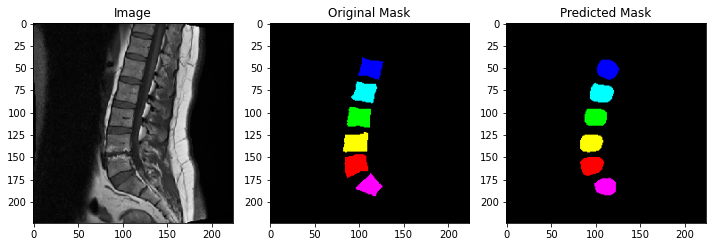

In [65]:
from skimage import io
from skimage import color
from skimage import segmentation

with torch.no_grad():
  model.eval()
  image = cv2.imread(ex_img_dir)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = image.astype("float32") / 255.0
  image = cv2.resize(image, (config.INPUT_IMAGE_WIDTH, config.INPUT_IMAGE_HEIGHT), interpolation = cv2.INTER_NEAREST)
  orig = image.copy()

  gtMask = cv2.imread(ex_label_dir)
  gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_WIDTH, config.INPUT_IMAGE_HEIGHT), interpolation = cv2.INTER_NEAREST)
  gt_Mask_t = torch.tensor(gtMask)

  image = np.transpose(image, (2, 0, 1))
  image = np.expand_dims(image, 0)
  image = torch.from_numpy(image).to(config.DEVICE)
  predMask = model(image)
  predMask = predMask['out']
  predMask = torch.argmax(predMask, 1).detach().cpu().squeeze()
  #print(predMask.shape)
  predMask_RGB = IntToRGB(predMask)

  y_true, y_pred = onehot(gtMask, predMask)
  dice_score = dice_coef_multilabel(y_true, y_pred, config.NUM_CLASS)
  print(f'For original mask and predicted mask {dice_score}')

  prepare_plot(orig, gtMask, predMask_RGB)

In [27]:
def make_predictions(model, imagePath, labelPath, showPlot=True):
	# set model to evaluation mode
  model.eval()
	# turn off gradient tracking
  with torch.no_grad():

    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float32") / 255.0
    image = cv2.resize(image, (config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_HEIGHT), interpolation = cv2.INTER_NEAREST)
    orig = image.copy()

    groundTruthPath = labelPath
    gtMask = cv2.imread(groundTruthPath)
    gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_HEIGHT), interpolation = cv2.INTER_NEAREST)
    gt_Mask_t = torch.tensor(gtMask)
 
    image = np.transpose(image, (2, 0, 1))
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image).to(config.DEVICE)
    predMask = model(image)
    predMask = predMask['out']
    predMask = torch.argmax(predMask, 1).detach().cpu().squeeze()
    predMask_RGB = IntToRGB(predMask)
 
    y_true, y_pred = onehot(gtMask, predMask)
    dice_score = dice_coef_multilabel(y_true, y_pred, config.NUM_CLASS)
    #jaccard = jaccard_index(gt_Mask_t, predMask_np)
		# prepare a plot for visualization
    if (showPlot):
      print("dice_score = ", dice_score)
      prepare_plot(orig, gtMask, predMask_RGB)
    return dice_score

[INFO] loading up test image paths...
[INFO] load up model...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.9142923542290584


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.8989602728979366


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.8801642417126813


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.9159781685835497


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.9082694324350109


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.8640843488621293


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.8994991911925794


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.9087548827930089


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.9144078338499707


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.9127248128763769
[0.9142923542290584, 0.8989602728979366, 0.8801642417126813, 0.9159781685835497, 0.9082694324350109, 0.8640843488621293, 0.8994991911925794, 0.9087548827930089, 0.9144078338499707, 0.9127248128763769]


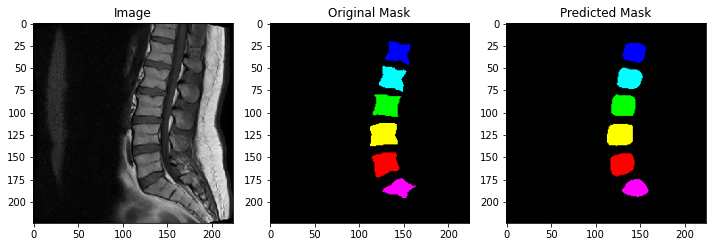

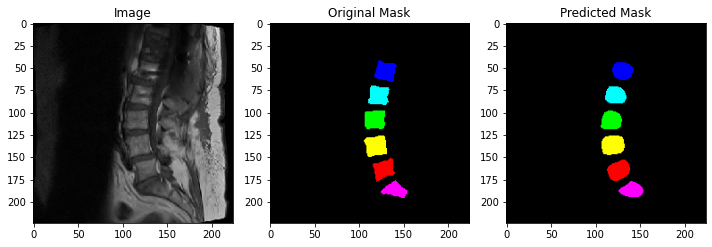

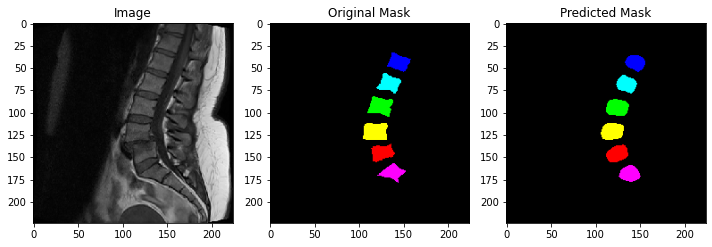

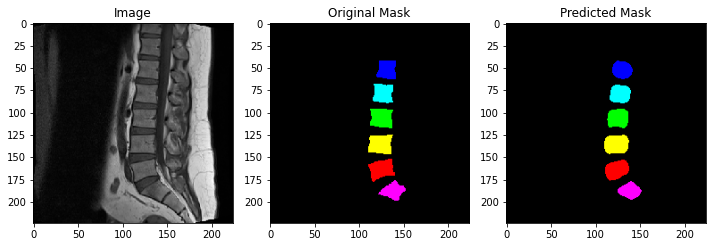

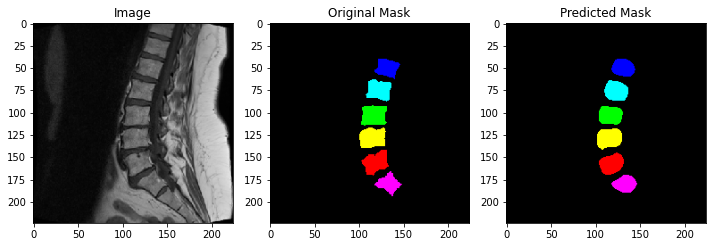

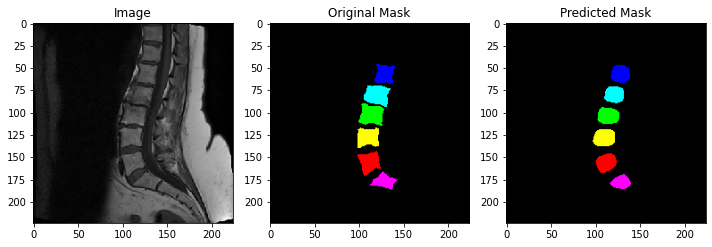

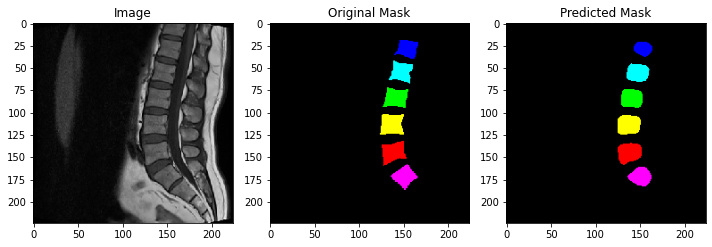

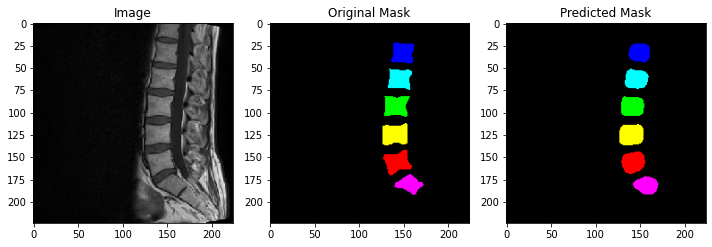

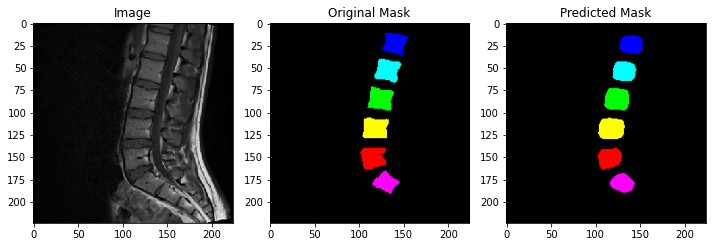

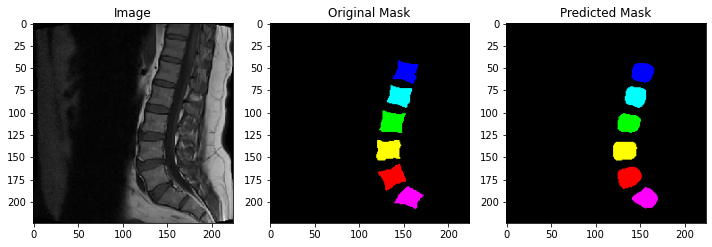

In [28]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
#imagePaths = open(config.TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(os.listdir(image_dir), size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
model = torch.load(config.MODEL_PATH).to(config.DEVICE)
# iterate over the randomly selected test image paths
dice_score_list = []
for path in imagePaths:
	# make predictions and visualize the results
  temp = path
  path = os.path.join(image_dir, temp)
  label_path = os.path.join(label_dir, temp)
  dice_score= make_predictions(model, path, label_path)
  dice_score_list.append(dice_score)

print(dice_score_list)

## Box Plot of Dice Score
- just the test set

Median of dice score:  0.9015251930504711
25th percentile of dice score :  0.8919015233708059
75th percentile of dice score :  0.9067298745242764


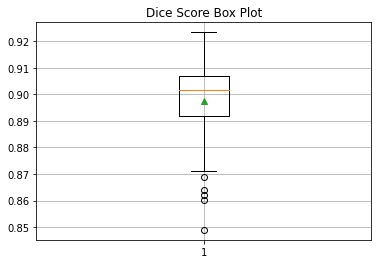

In [29]:
#Make box plots using the dice score of all the test results
imagePaths = val_list
model = torch.load(config.MODEL_PATH).to(config.DEVICE)
# iterate over all the test images
dice_score_list = []

for path in imagePaths:
	# make predictions and visualize the results
  temp = path
  path = os.path.join(image_dir, temp)
  label_path = os.path.join(label_dir, temp)
  score = make_predictions(model, path, label_path, showPlot=False)
  dice_score_list.append(score)

plt.boxplot(dice_score_list, showmeans=True)
plt.title("Dice Score Box Plot")
plt.grid()
print("Median of dice score: ", np.median(dice_score_list))
print("25th percentile of dice score : ",
       np.percentile(dice_score_list, 25))
print("75th percentile of dice score : ",
       np.percentile(dice_score_list, 75))

In [38]:
cervical_img_dir = "/content/drive/MyDrive/lumbar_mid_sagittal/sub-amu01_T1w.nii.gz"
cervical_img = nib.load(cervical_img_dir).get_fdata()
test_img = cervical_img.transpose(0,2,1)
test_img = np.rot90(test_img, 2)[95, :, :]
print(type(test_img))

<class 'numpy.ndarray'>


## Lumbar Spine to Cervical Spine (Does this work?) No

255.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


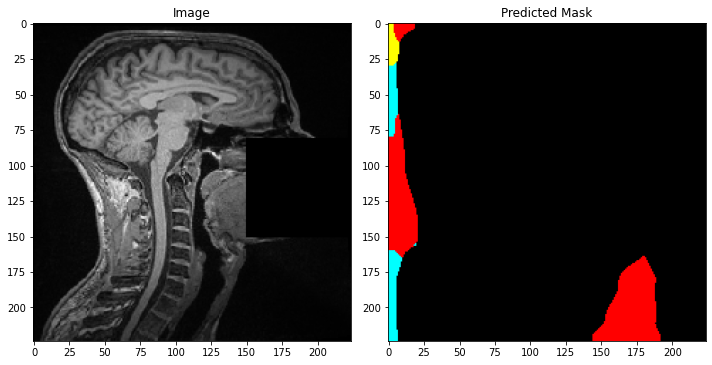

In [81]:
model.eval()
with torch.no_grad():
  #image = cv2.imread(test_img)
  #image = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
  image = test_img.astype("float32") /np.max(test_img) * 255
  #cv2.imread(image)
  image = cv2.resize(image, (config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_HEIGHT), interpolation = cv2.INTER_NEAREST)
  orig = image.copy()
  print(np.max(orig))
  image = np.zeros((1, 3, config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_HEIGHT))
  image[0, 0, :, :] = orig
  image[0, 1, :, :] = orig
  image[0, 2, :, :] = orig

  #image = np.transpose(image, (2, 0, 1))
  #image = np.expand_dims(image, 0)
  #image = torch.from_numpy(image)
  image = torch.Tensor(image).to(config.DEVICE)
  predMask = model(image)
  predMask = predMask['out']
  predMask = torch.argmax(predMask, 1).detach().cpu().squeeze()
  predMask_RGB = IntToRGB(predMask)
  #print(predMask_RGB.shape)

  #y_true = F.one_hot(torch.LongTensor(RGBtoInt(predMask))).numpy()
  
  figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
  ax[0].imshow(orig, cmap='gray')
  ax[1].imshow(predMask_RGB)
	# set the titles of the subplots
  ax[0].set_title("Image")
  ax[1].set_title("Predicted Mask")
	# set the layout of the figure and display it
  figure.tight_layout()
  figure.show()